# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2017


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2017-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    118,453    4,755   2,395   1,995   1,896
  1           9thStreet    115,466    4,304   3,035   2,578   2,175
  2          14thStreet    215,494    8,670   4,090   3,486   4,155
  3          23rdStreet    219,097    9,486   2,754   2,326   3,366
  4          33rdStreet    835,647   34,148  14,289  13,070  15,094
  5     UPTOWN SUBTOTAL  1,504,157   61,363  26,563  23,455  26,686
  6                 WTC  1,329,577   57,540  16,562  14,810  19,236
  7   NEW YORK SUBTOTAL  2,833,734  118,903  43,125  38,265  45,922,
                       0          1        2       3       4        5
  0               Newark    681,575   29,428   8,961   6,870   11,409
  1             Harrison    198,626    8,568   2,666   2,024    3,240
  2       Journal Square    628,253   25,349  12,013   9,501   12,858
  3         Grove Street    489,797   20,123   9,362   6,639    8,346
  4       Exchange Place    395,56

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

0          1        2        3       4       5  \
0    Christopher Street    118,453    4,755    2,395   1,995   1,896   
1             9thStreet    115,466    4,304    3,035   2,578   2,175   
2            14thStreet    215,494    8,670    4,090   3,486   4,155   
3            23rdStreet    219,097    9,486    2,754   2,326   3,366   
4            33rdStreet    835,647   34,148   14,289  13,070  15,094   
..                  ...        ...      ...      ...     ...     ...   
4        Exchange Place    374,331   16,360    4,910   3,868   3,246   
5      Pavonia/ Newport    460,277   18,994    8,233   6,875   4,855   
6               Hoboken    665,412   28,052   11,938   8,244   3,455   
7   NEW JERSEY SUBTOTAL  3,527,333  146,796   62,595  48,934  33,769   
8         MONTHLY TOTAL  6,405,132  265,519  114,860  91,394  63,484   

          date  
0   2017-01-01  
1   2017-01-01  
2   2017-01-01  
3   2017-01-01  
4   2017-01-01  
..         ...  
4   2017-12-01  
5   2017-12-01  
6   2017-12-01  
7   2017-12-01  
8   2017-12-01  

[204 rows x 7 columns]

In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

station    total  avg weekday  avg sat  avg sun  avg holiday  \
0    Christopher Street   118453         4755     2395     1995         1896   
1             9thStreet   115466         4304     3035     2578         2175   
2            14thStreet   215494         8670     4090     3486         4155   
3            23rdStreet   219097         9486     2754     2326         3366   
4            33rdStreet   835647        34148    14289    13070        15094   
..                  ...      ...          ...      ...      ...          ...   
4        Exchange Place   374331        16360     4910     3868         3246   
5      Pavonia/ Newport   460277        18994     8233     6875         4855   
6               Hoboken   665412        28052    11938     8244         3455   
7   NEW JERSEY SUBTOTAL  3527333       146796    62595    48934        33769   
8         MONTHLY TOTAL  6405132       265519   114860    91394        63484   

         month  
0   2017-01-01  
1   2017-01-01  
2   2017-01-01  
3   2017-01-01  
4   2017-01-01  
..         ...  
4   2017-12-01  
5   2017-12-01  
6   2017-12-01  
7   2017-12-01  
8   2017-12-01  

[204 rows x 7 columns]

In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

station  avg daily  total weekday  total sat  total sun  \
0    Christopher Street       3821          95104       9581       9976   
1             9thStreet       3725          86086      12141      12889   
2            14thStreet       6951         173394      16361      17429   
3            23rdStreet       7068         189714      11018      11632   
4            33rdStreet      26956         682956      57156      65348   
..                  ...        ...            ...        ...        ...   
4        Exchange Place      12075         327198      24548      19339   
5      Pavonia/ Newport      14848         379880      41165      34377   
6               Hoboken      21465         561045      59690      41222   
7   NEW JERSEY SUBTOTAL     113785        2935925     312972     244667   
8         MONTHLY TOTAL     206617        5310378     574298     456972   

    total holiday       month  
0            3792  2017-01-01  
1            4350  2017-01-01  
2            8310  2017-01-01  
3            6733  2017-01-01  
4           30187  2017-01-01  
..            ...         ...  
4            3246  2017-12-01  
5            4855  2017-12-01  
6            3455  2017-12-01  
7           33769  2017-12-01  
8           63484  2017-12-01  

[204 rows x 7 columns]

In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2017-01-01 Christopher Street        3821         4755     2395     1995   
           9thStreet                 3725         4304     3035     2578   
           14thStreet                6951         8670     4090     3486   
           23rdStreet                7068         9486     2754     2326   
           33rdStreet               26956        34148    14289    13070   
...                                   ...          ...      ...      ...   
2017-12-01 Exchange Place           12075        16360     4910     3868   
           Pavonia/ Newport         14848        18994     8233     6875   
           Hoboken                  21465        28052    11938     8244   
           NEW JERSEY SUBTOTAL     113785       146796    62595    48934   
           MONTHLY TOTAL           206617       265519   114860    91394   

                                avg holiday    total  total weekday  \
month      station                                                    
2017-01-01 Christopher Street          1896   118453          95104   
           9thStreet                   2175   115466          86086   
           14thStreet                  4155   215494         173394   
           23rdStreet                  3366   219097         189714   
           33rdStreet                 15094   835647         682956   
...                                     ...      ...            ...   
2017-12-01 Exchange Place              3246   374331         327198   
           Pavonia/ Newport            4855   460277         379880   
           Hoboken                     3455   665412         561045   
           NEW JERSEY SUBTOTAL        33769  3527333        2935925   
           MONTHLY TOTAL              63484  6405132        5310378   

                                total sat  total sun  total holiday  
month      station                                                   
2017-01-01 Christopher Street        9581       9976           3792  
           9thStreet                12141      12889           4350  
           14thStreet               16361      17429           8310  
           23rdStreet               11018      11632           6733  
           33rdStreet               57156      65348          30187  
...                                   ...        ...            ...  
2017-12-01 Exchange Place           24548      19339           3246  
           Pavonia/ Newport         41165      34377           4855  
           Hoboken                  59690      41222           3455  
           NEW JERSEY SUBTOTAL     312972     244667          33769  
           MONTHLY TOTAL           574298     456972          63484  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

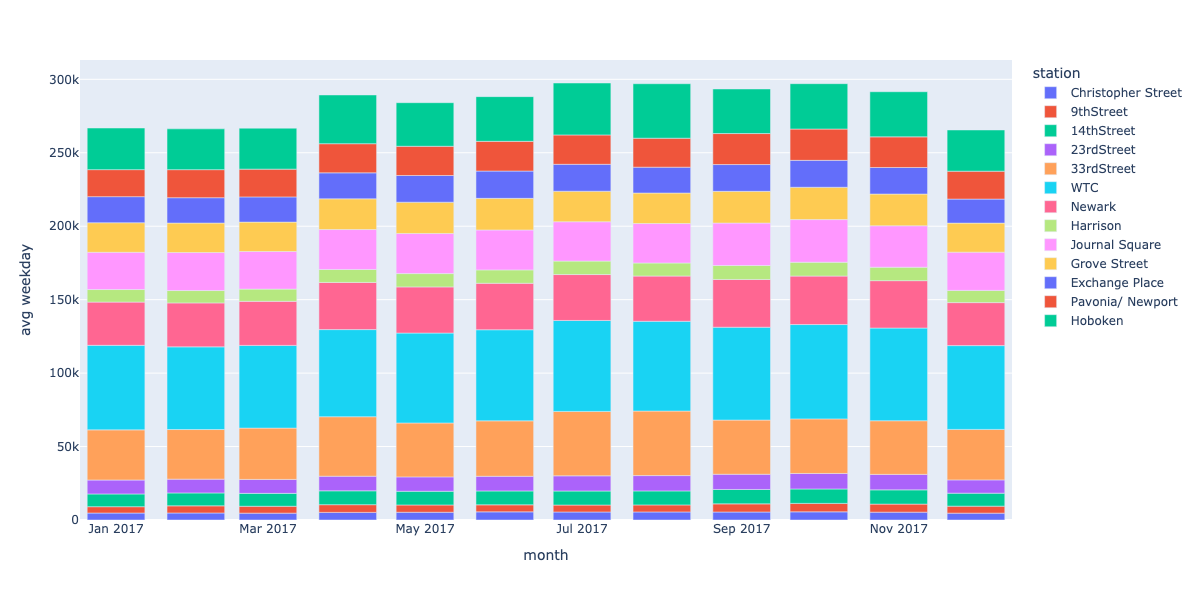

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))